# Model Comparison

This file will train three models (SVD, KNN, and NMF) and compare results.  The file also uses grids of hyperparameter values to analyse performance using different hyperparameters which can be used to tune the best performaing model.

*Note that this file was run with a number of different combinations of hyperparameter values, the ones included in this file are for illustration.*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, SVD, KNNBasic, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import accuracy

In [2]:
# Define the data files
interaction_data_file = 'Data/interaction_data_prepared.csv'

# Import data file into dataframe
interaction_dataframe = pd.read_csv(interaction_data_file)

In [3]:
# Prepare data for Surprise using the weighted interactions
reader = Reader(rating_scale=(interaction_dataframe['SCORE'].min(), interaction_dataframe['SCORE'].max()))
data = Dataset.load_from_df(interaction_dataframe[['USER_ID', 'BRAND_ID', 'SCORE']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2)

In [4]:
# Define hyperparameter grids for each model
param_grid_svd = {
    'n_factors': [50, 100, 150, 200],
    'n_epochs': [50, 100, 200, 300],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}

param_grid_knn = {
    'k': [5, 10, 20, 50],
    'sim_options': {'name': ['msd', 'cosine'], 'user_based': [False, True]}
}

param_grid_nmf = {
    'n_factors': [15, 30, 50, 100],
    'n_epochs': [50, 100, 150, 200],
    'reg_pu': [0.06, 0.1],
    'reg_qi': [0.06, 0.1]
}

# Perform grid search for each model
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse'], cv=3)
gs_knn = GridSearchCV(KNNBasic, param_grid_knn, measures=['rmse'], cv=3)
gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse'], cv=3)

# Fit grid
gs_svd.fit(data)
gs_knn.fit(data)
gs_nmf.fit(data)

# Extract best models and their parameters
best_svd = gs_svd.best_estimator['rmse']
best_knn = gs_knn.best_estimator['rmse']
best_nmf = gs_nmf.best_estimator['rmse']

results_svd = cross_validate(best_svd, data, measures=['RMSE', 'MAE'], cv=5, return_train_measures=True)
results_knn = cross_validate(best_knn, data, measures=['RMSE', 'MAE'], cv=5, return_train_measures=True)
results_nmf = cross_validate(best_nmf, data, measures=['RMSE', 'MAE'], cv=5, return_train_measures=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

### RMSE Score Overview

Here we plot the RMSE scores for each model.

**Observations**

- The Singular Value Decomposition (SVD) model seems to be the best performing model over the range of hyperparameters we used for training.

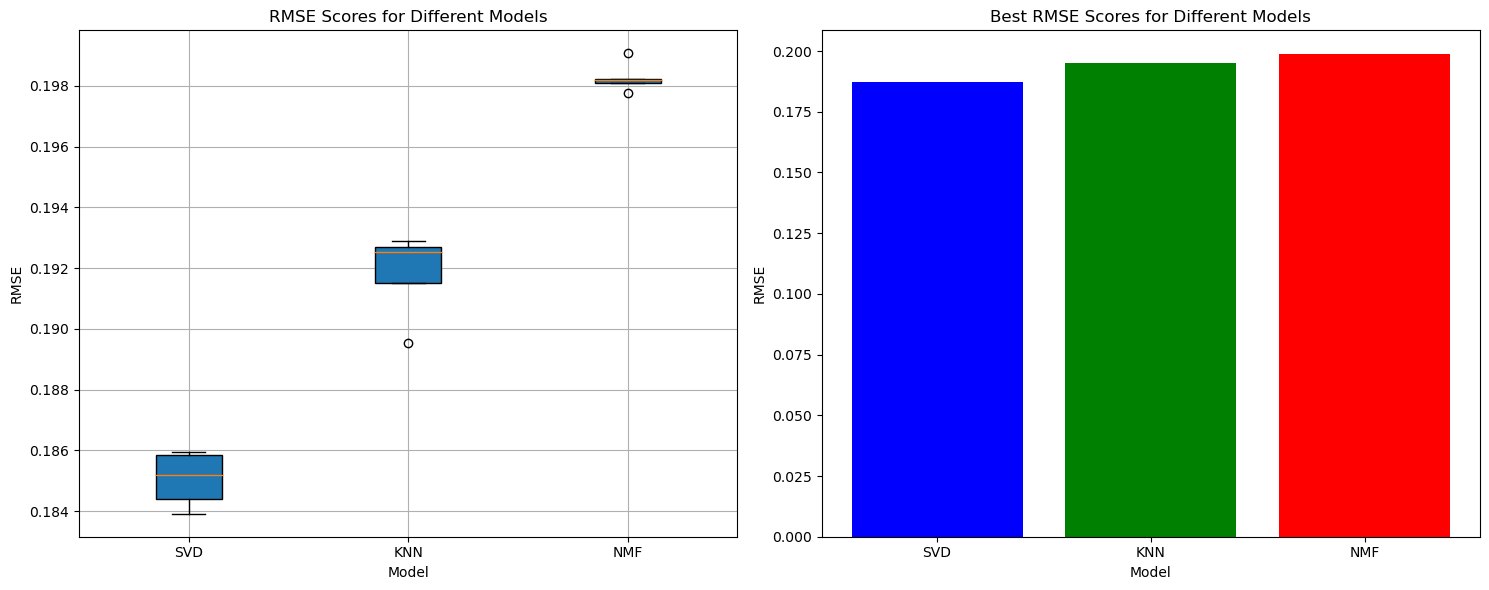

In [5]:
# Access the best scores
best_svd_rmse = gs_svd.best_score['rmse']
best_knn_rmse = gs_knn.best_score['rmse']
best_nmf_rmse = gs_nmf.best_score['rmse']

# Prepare the data
boxplot_data = [results_svd['test_rmse'], results_knn['test_rmse'], results_nmf['test_rmse']]
best_scores = [best_svd_rmse, best_knn_rmse, best_nmf_rmse]
models = ['SVD', 'KNN', 'NMF']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot of RMSE scores for each model
axes[0].boxplot(boxplot_data, labels=models, patch_artist=True)
axes[0].set_title('RMSE Scores for Different Models')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')
axes[0].grid(True)

# Bar plot of best RMSE scores for each model
axes[1].bar(models, best_scores, color=['blue', 'green', 'red'])
axes[1].set_title('Best RMSE Scores for Different Models')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Model')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Hyperparameter Tuning

Here we plot the various RMSE scores across the grid of hyperparameters (n_factors and n_epochs for SVD and NMP, and k and sim_options for KNN).  The optimum values are output as part of the script.

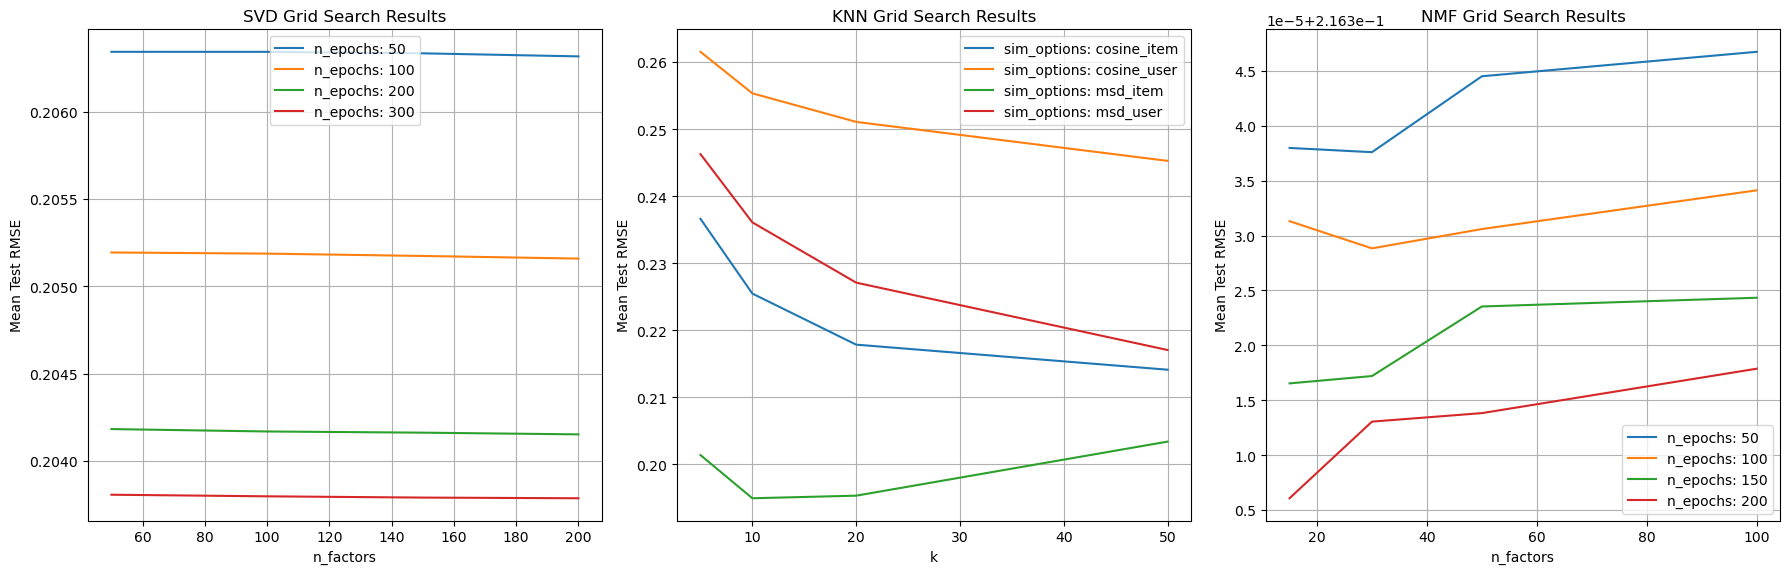

In [6]:
# Define a function to plot grid search results for SVD and NMF
def plot_grid_search(ax, cv_results, param_grid, param_name1, param_name2, title):

    scores_mean = np.array(cv_results['mean_test_rmse'])
    scores_params = cv_results['params']

    param1_values = sorted({params[param_name1] for params in scores_params})
    param2_values = sorted({params[param_name2] for params in scores_params})
    
    scores_mean_matrix = np.zeros((len(param2_values), len(param1_values)))

    for i, val2 in enumerate(param2_values):
        for j, val1 in enumerate(param1_values):
            for idx, params in enumerate(scores_params):
                if params[param_name1] == val1 and params[param_name2] == val2:
                    scores_mean_matrix[i, j] = scores_mean[idx]

    for idx, val in enumerate(param2_values):
        ax.plot(param1_values, scores_mean_matrix[idx], label=f'{param_name2}: {val}')
    
    ax.set_title(title)
    ax.set_xlabel(param_name1)
    ax.set_ylabel('Mean Test RMSE')
    ax.legend(loc='best')
    ax.grid(True)

# Define a function to plot grid search results for KNN
def plot_knn_grid_search(ax, cv_results, param_grid, param_name1, param_name2, title):
    
    scores_mean = np.array(cv_results['mean_test_rmse'])
    scores_params = cv_results['params']

    param1_values = sorted({params[param_name1] for params in scores_params})
    param2_values = sorted({params[param_name2]['name'] + ('_user' if params[param_name2]['user_based'] else '_item') for params in scores_params})
    
    scores_mean_matrix = np.zeros((len(param2_values), len(param1_values)))

    for i, val2 in enumerate(param2_values):
        for j, val1 in enumerate(param1_values):
            for idx, params in enumerate(scores_params):
                val2_combined = params[param_name2]['name'] + ('_user' if params[param_name2]['user_based'] else '_item')
                if params[param_name1] == val1 and val2_combined == val2:
                    scores_mean_matrix[i, j] = scores_mean[idx]

    for idx, val in enumerate(param2_values):
        ax.plot(param1_values, scores_mean_matrix[idx], label=f'{param_name2}: {val}')
    
    ax.set_title(title)
    ax.set_xlabel(param_name1)
    ax.set_ylabel('Mean Test RMSE')
    ax.legend(loc='best')
    ax.grid(True)

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot grid search results for SVD
plot_grid_search(axes[0], gs_svd.cv_results, param_grid_svd, 'n_factors', 'n_epochs', 'SVD Grid Search Results')

# Plot grid search results for KNN
plot_knn_grid_search(axes[1], gs_knn.cv_results, param_grid_knn, 'k', 'sim_options', 'KNN Grid Search Results')

# Plot grid search results for NMF
plot_grid_search(axes[2], gs_nmf.cv_results, param_grid_nmf, 'n_factors', 'n_epochs', 'NMF Grid Search Results')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [7]:
# Print the best parameters for each model
print("Best hyperparameters for SVD:", gs_svd.best_params['rmse'])
print("Best hyperparameters for KNN:", gs_knn.best_params['rmse'])
print("Best hyperparameters for NMF:", gs_nmf.best_params['rmse'])

# Calculate mean RMSE for each model
mean_rmse_svd = results_svd['test_rmse'].mean()
mean_rmse_knn = results_knn['test_rmse'].mean()
mean_rmse_nmf = results_nmf['test_rmse'].mean()

print()

# Determine the best performing model
best_model = min((mean_rmse_svd, 'SVD'), (mean_rmse_knn, 'KNN'), (mean_rmse_nmf, 'NMF'))
print(f"The best performing model is {best_model[1]} with a mean RMSE of {best_model[0]}")


Best hyperparameters for SVD: {'n_factors': 50, 'n_epochs': 300, 'lr_all': 0.005, 'reg_all': 0.02}
Best hyperparameters for KNN: {'k': 10, 'sim_options': {'name': 'msd', 'user_based': False}}
Best hyperparameters for NMF: {'n_factors': 50, 'n_epochs': 200, 'reg_pu': 0.06, 'reg_qi': 0.06}

The best performing model is SVD with a mean RMSE of 0.1850596346663128
